## S08 T01: Tasca Feature Engineering

In [1]:
import math

import numpy as np
from numpy import random
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

Aprèn a gestionar paràmetres amb Python.

#### Exercici 1: Agafa un conjunt de dades de tema esportiu que t'agradi i normalitza els atributs categòrics en dummy. Estandaritza els atributs numèrics amb StandardScaler.

El dataset escollit és sobre els Jocs Olímpics de Tokyo 2020. S'hi pot veure el detall de totes les competicions que van tenir lloc, juntament amb l'edat, nacionalitat, classificació i medalles de cada atleta

Columnes: 
- Unnamed: 0 : # de fila
- Code: codi únic de cada atleta
- Name: nom de l'atleta (COGNOM Nom)
- Gender: Male o Female
- Age: edat dels atletes
- NOC: Comité Olímpic Nacional (206 en total)
- Country: país (206 en total)
- Discipline: cada codi indica una disciplina específica (46 en total)
- Sport: esport equivalent al codi de la columna anterior (46 en total)
- Event: tipus de competició (per equips, individual, masculina, femenina, etc.)
- Rank: classificacio de cada Atleta per 'Event' al que han participat, sent 1 la 1a posició.
- Medal: medalla (Gold, Silver, Bronze o NaN)

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
olympics = pd.read_csv("/content/drive/My Drive/jupyter/2020_Olympics_Dataset.csv", encoding = 'latin-1')

olympics = olympics.drop('Unnamed: 0', 1)
olympics = olympics.drop('Code', 1) # la columna Name conté els mateixos unics valors que Code
olympics = olympics.drop('NOC', 1) #la columna Country conté la mateixa informació de forma més clara
olympics = olympics.drop('Discipline', 1) #la columna Sport conté la mateixa informació de forma més clara
olympics = olympics.rename(columns={"Rank": "Athlete_Rank"})

olympics.sample(5)

Mounted at /content/drive


,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal
15078,ZIRK Kregor,Male,22,Estonia,Swimming,Men's 200m Butterfly,NaN,NaN
4736,GRINEV Vladislav,Male,25,Russia,Swimming,Men's 4 x 100m Freestyle Relay Team,7.0,NaN
3716,EYENGA MBOOSI Jeanne Gaelle,Female,22,Cameroon,Weightlifting,Women's 76kg,11.0,NaN
1380,BISHINDEE Urantungalag,Female,44,Mongolia,Archery,Mixed Team,27.0,NaN
6577,KINCAID William,Male,28,United States,Athletics,"Men's 10,000m",15.0,NaN


com que el dataset que hem escollit només té 2 columnes numèriques, carregarem un altre dataset que complementa el que ja tenim, afegint el nombre de medalles d'or, de plata i de bronze per cada país i afegint nous ranquings.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
medals = pd.read_csv("/content/drive/My Drive/jupyter/Tokyo_Olympic_Medals.csv", encoding = 'latin-1')
medals = medals.rename(columns={"Rank": "Gold_Rank"})

medals.sample(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Gold_Rank,Country,Gold,Silver,Bronze,Total,Rank_by_Total
53,54,Egypt,1,1,4,6,39
52,53,Austria,1,1,5,7,33
0,1,United States,39,41,33,113,1
32,33,Georgia,2,5,1,8,29
23,24,Switzerland,3,4,6,13,20


In [4]:
olympics = pd.merge(olympics, medals, on =['Country'])
olympics.sample(5)

,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
9829,GALLAGHER Laura,Female,32,Great Britain,Trampoline Gymnastics,Women,NaN,NaN,4,22,21,22,65,4
9116,CHANCE Olivia,Female,27,New Zealand,Football,Women Team,12.0,NaN,13,7,6,7,20,13
12822,DHERS Daniel,Male,36,Venezuela,Cycling BMX Freestyle,Men's Park,2.0,Silver,47,1,3,0,4,47
340,JIMENEZ VICENTE Lucia,Female,24,Spain,Hockey,Women Team,7.0,NaN,22,3,8,6,17,17
12666,FLORENTINO Robert,Male,24,Dominican Republic,Judo,Men -90 kg,17.0,NaN,68,0,3,2,5,42


In [5]:
olympics.shape

(14108, 14)

#### Data Preparation

In [5]:
# Analitzem la columna 'Medal'

olympics.Medal.unique()

array([nan, 'Gold', 'Silver', 'Bronze'], dtype=object)

En aquest cas els 'NaN' casos sí que és un valor que ens dóna informació, ja que indica aquells atletes que no han aconseguit cap medalla. Canviarem NaN per None per tal de que al convertir les variables categòriques a dummy ho tingui en compte. 

In [6]:
olympics.Medal = olympics.Medal.fillna('None')
olympics.sample(5)

,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
836,LANZI Asia,Female,19,Italy,Skateboarding,Women's Street,14.0,None,10,10,10,20,40,7
4897,SERIKZHANOV Yerlan,Male,26,Kazakhstan,Judo,Men -66 kg,9.0,None,83,0,0,8,8,29
7514,INDERGAND Linda,Female,28,Switzerland,Cycling Mountain Bike,Women's Cross-country,3.0,Bronze,24,3,4,6,13,20
2618,SCHUMANN Damien,Male,33,Australia,Beach Volleyball,Men Team,19.0,None,6,17,7,22,46,6
4081,ALMUTAIRI Saeid,Male,52,Saudi Arabia,Shooting,Skeet Men,22.0,None,78,0,1,0,1,77


In [7]:
# Analitzem la columna Name 

olympics.Name.value_counts()

HALL James                    10
SUN Wei                        8
SOUZA Caio                     8
DAUSER Lukas                   8
BARRETTO JUNIOR Francisco      8
                              ..
ZHAO Shuai                     1
BEKA BEKA Alexis               1
WHITE Felicity                 1
PATINO BEDOYA Paula Andrea     1
WINDLE Jordan                  1
Name: Name, Length: 10726, dtype: int64

Atés que la columna Name conté 10.726 valors diferents, no la inclourem dins de les variables categoriques a normalitzar ja que això ens afegiria 10.726 columnes noves al nostre dataset.

In [8]:
# analitzem la columna Country:

olympics.Country.value_counts()

United States      856
Japan              787
Australia          638
Germany            597
China              574
                  ... 
San Marino           8
North Macedonia      8
Syria                6
Grenada              6
Bermuda              2
Name: Country, Length: 93, dtype: int64

Veient que convertir la columnna "Country" a dummy afegiria 93 noves columnes al dataset, crearem una nova columna amb els 7 continents i afegirem cada país al continent que pertany. 

Per fer-ho farem servir pycountry_convert. La funció converteix primer el nom d'un país en codi ISO alpha-2 i posteriorment aquest codi al codi del continent. Tot i així, iniciar-la, hem obtingut algunes excepcions on el país que es mostrava al dataset no es reconeixia per convertir-ho a codi de país i hem hagut d'introduir algunes excepcions.

In [8]:
!pip install pycountry-convert

     |████████████████████████████████| 10.1 MB 37.9 MB/s 
     |████████████████████████████████| 280 kB 41.5 MB/s 
     |████████████████████████████████| 213 kB 64.9 MB/s 
     |████████████████████████████████| 280 kB 69.4 MB/s 
     |████████████████████████████████| 280 kB 79.3 MB/s 
     |████████████████████████████████| 280 kB 74.7 MB/s 
     |████████████████████████████████| 279 kB 49.1 MB/s 
     |████████████████████████████████| 279 kB 72.4 MB/s 
     |████████████████████████████████| 272 kB 68.9 MB/s 
     |████████████████████████████████| 272 kB 72.1 MB/s 
     |████████████████████████████████| 272 kB 50.6 MB/s 
     |████████████████████████████████| 270 kB 71.3 MB/s 
     |████████████████████████████████| 270 kB 70.7 MB/s 
     |████████████████████████████████| 270 kB 53.0 MB/s 
     |████████████████████████████████| 248 kB 46.2 MB/s 
     |████████████████████████████████| 247 kB 45.0 MB/s 
     |████████████████████████████████| 246 kB 61.6 MB/s 
     |███████

In [9]:
import pycountry_convert as pc

exceptions = []
test = set()

for country in olympics.Country:
  try:
    pc.country_name_to_country_alpha2(country, cn_name_format="default")
    exceptions.append(country)
  except:
    test.add(country)

print(len(test)) # imprimim el número d'excepcions amb les que ens trobarem
print(test) # imprimim les excepcions amb les que ens trobarem

3
{'Kosovo', 'Chinese Taipei', 'Hong Kong, China'}


In [10]:
def country_code_func(x):
  
  codes = []

  for country in olympics.Country:    
    if country == 'Hong Kong, China':
      country_code = pc.country_name_to_country_alpha2('Hong Kong', cn_name_format="default") #canviem 'Hong Kong, China' per 'Hong Kong', ja que és el nom estàndard que reconeix la ISO alpha-2
      codes.append(country_code)
    elif country == 'Chinese Taipei':
      country_code = pc.country_name_to_country_alpha2('Taiwan', cn_name_format="default") #canviem 'Chinese Taipei' per 'Taiwan', ja que és el nom estàndard que reconeix la ISO alpha-2
      codes.append(country_code)
    elif country == 'Kosovo': # Kosovo no està inclós com a país estàndard de la ISO, tot i que se li assigna de forma no-oficial el codi XK.
      codes.append('XK')
    else:
      country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
      codes.append(country_code)
  
  return codes

olympics['Codes'] = country_code_func(olympics.Country)
olympics.sample(5)

,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total,Codes
11958,HARTKOPF Lourdes,Female,25,Argentina,Sailing,Women's Two Person Dinghy - 470 Team,20.0,None,72,0,1,2,3,60,AR
5268,KOMINAMI Takuto,Male,26,Japan,Athletics,Men's Javelin Throw,NaN,None,3,27,14,17,58,5,JP
7724,MARAIS Marizen,Female,25,South Africa,Hockey,Women Team,12.0,None,52,1,2,0,3,60,ZA
5821,BEVERIDGE Allison,Female,28,Canada,Cycling Track,Women's Omnium,9.0,None,11,7,6,11,24,11,CA
640,CAVALLI Marta,Female,23,Italy,Cycling Road,Women's Road Race,8.0,None,10,10,10,20,40,7,IT


In [11]:
def continent_codes(x):

  continent_codes = []

  for country_code in olympics.Codes:
    if country_code == 'Refugees':
      continent_codes.append('Refugees')
    elif country_code == 'TL':
      continent_codes.append('AS')
    else:
      continent_name = pc.country_alpha2_to_continent_code(country_code)
      continent_codes.append(continent_name)
  return continent_codes


olympics['Continent'] = continent_codes(olympics.Codes)
olympics = olympics.drop('Codes', 1)
olympics.sample(5)

,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total,Continent
580,BENATI Lorenzo,Male,19,Italy,Athletics,Men's 4 x 400m Relay Team,7.0,None,10,10,10,20,40,7,EU
2601,ROUSSEAU Cassiel,Male,20,Australia,Diving,Men's 10m Platform,8.0,None,6,17,7,22,46,6,OC
7972,TIMO Barbara,Female,30,Portugal,Judo,Women -70 kg,9.0,None,57,1,1,2,4,47,EU
8479,GRAJALES Crisanto,Male,34,Mexico,Triathlon,Men's Individual,31.0,None,84,0,0,4,4,47,NA
5872,COLLEY Shay,Female,25,Canada,Basketball,Women Team,9.0,None,11,7,6,11,24,11,NA


In [12]:
olympics.Continent.value_counts()

EU    6610
AS    3045
NA    1868
OC     949
AF     836
SA     800
Name: Continent, dtype: int64

Ja tenim la nova columna creada que, un cop passat a dummy, ens permetrà crear només 6 noves columnes (enlloc de 93). els valors son els següents:
* EU: Europa
* AS: Asia
* NA: North America
* AF: Àfrica
* OC: Oceania
* SA: South America

In [13]:
# analitzem la columna Event

olympics.Event.value_counts()

Men Team                  1388
Women Team                1244
Mixed Team                 171
Women's Singles            161
Men's Singles              155
                          ... 
Women's Kumite -61kg         9
Men's 4 x 400m Relay         6
Women's 4 x 100m Relay       5
Men's 4 x 100m Relay         2
Women's 4 x 400m Relay       2
Name: Event, Length: 306, dtype: int64

Atés que la columna "Event" compta amb 306 unics valors i la columna Sport amb 46, tampoc els inclourem en la normalització de les variables categòriques.

#### Normalització dels atributs categòrics a Dummy

In [14]:
var_cat = olympics.iloc[:, [1, 7, 14]]
dummy = pd.get_dummies(var_cat)
dummy.sample(5)

,Gender_Female,Gender_Male,Medal_Bronze,Medal_Gold,Medal_None,Medal_Silver,Continent_AF,Continent_AS,Continent_EU,Continent_NA,Continent_OC,Continent_SA
998,1,0,1,0,0,0,0,0,1,0,0,0
13253,1,0,0,0,1,0,0,0,1,0,0,0
11537,1,0,0,0,1,0,0,1,0,0,0,0
10436,0,1,1,0,0,0,0,0,1,0,0,0
11637,1,0,0,0,1,0,0,0,1,0,0,0


In [15]:
no_dummy = olympics.iloc[:, [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]]
df = pd.concat([no_dummy, dummy], axis=1)
df.sample(5)

,Name,Age,Country,Sport,Event,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total,Gender_Female,Gender_Male,Medal_Bronze,Medal_Gold,Medal_None,Medal_Silver,Continent_AF,Continent_AS,Continent_EU,Continent_NA,Continent_OC,Continent_SA
11719,LELIOR Anat,21,Israel,Surfing,Women,17.0,40,2,0,2,4,47,1,0,0,0,1,0,0,1,0,0,0,0
6449,ZAJAC Thomas,35,Austria,Sailing,Mixed Multihull - Nacra 17 Foiling Team,11.0,53,1,1,5,7,33,0,1,0,0,1,0,0,0,1,0,0,0
11199,LIN Wenjun,24,China,Canoe Sprint,Women's Canoe Single 200m,6.0,2,38,32,18,88,2,1,0,0,0,1,0,0,1,0,0,0,0
6509,BIDA Sergey,28,Russia,Fencing,Men's Épée Individual,5.0,5,20,28,23,71,3,0,1,0,0,1,0,0,0,1,0,0,0
13399,OPATRNY Ales,39,Czech Republic,Equestrian,Jumping Individual,NaN,18,4,4,3,11,23,0,1,0,0,1,0,0,0,1,0,0,0


#### Estandarització dels atributs numèrics amb StandardScaler

Si estandaritzem els atributs numèrics vol dir que centrem les dades al voltant de la mitjana aritmètica del conjunt de dades (la mitjana tendeix a zero) i les dividim per la desviació estàndard del conjunt (la desviació estàndard tendeix a 1).

d'aquesta forma aconseguim que els atributs segueixin més o menys una distribució normal. 

In [16]:
olympics.head()

,Name,Gender,Age,Country,Sport,Event,Athlete_Rank,Medal,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total,Continent
0,AALERUD Katrine,Female,26,Norway,Cycling Road,Women's Road Race,37.0,None,20,4,2,2,8,29,EU
1,AALERUD Katrine,Female,26,Norway,Cycling Road,Women's Individual Time Trial,20.0,None,20,4,2,2,8,29,EU
2,ABELVIK ROED Magnus,Male,24,Norway,Handball,Men Team,7.0,None,20,4,2,2,8,29,EU
3,BERGERUD Torbjoern,Male,27,Norway,Handball,Men Team,7.0,None,20,4,2,2,8,29,EU
4,BJOERNSEN Kristian,Male,32,Norway,Handball,Men Team,7.0,None,20,4,2,2,8,29,EU


In [17]:
var_num = olympics[['Age', 'Athlete_Rank', 'Gold_Rank','Gold', 'Silver', 'Bronze', 'Total', 'Rank_by_Total']]
var_num = var_num.dropna()
var_num.shape

(10787, 8)

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

std_num = ss.fit_transform(var_num.values)
print ('mitjana: ' , round(std_num.mean(), 5)) 
print ('desv. estandard: ' , std_num.std())

mitjana:  0.0
desv. estandard:  1.0


com veiem, després de l'estandarització, la mitjan tendeix a 0 i la desviació estàndard a 1.

In [19]:
df_std = round(pd.DataFrame(std_num, columns = ['Age', 'Athlete_Rank', 'Gold_Rank','Gold', 'Silver', 'Bronze', 'Total', 'Rank_by_Total']), 3)
df_std.sample(5)

,Age,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
9104,0.117,-0.514,0.725,-0.778,-0.927,-1.036,-0.939,1.348
5113,-0.428,-0.802,-0.764,0.702,1.499,1.218,1.171,-0.878
303,-0.065,-0.514,-0.041,-0.695,-0.234,-0.607,-0.529,-0.170
7655,-0.972,-0.130,-0.807,0.866,0.893,1.111,0.982,-0.827
1216,1.568,-0.130,-0.637,-0.120,0.113,-0.070,-0.026,-0.524


In [20]:
round(df_std.describe(), 3)

,Age,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
count,10787.000,10787.000,10787.000,10787.000,10787.000,10787.000,10787.000,10787.000
mean,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.786,-0.898,-0.934,-0.942,-0.927,-1.251,-1.033,-0.979
25%,-0.609,-0.610,-0.722,-0.778,-0.754,-0.929,-0.844,-0.726
50%,-0.065,-0.322,-0.466,-0.367,-0.407,-0.178,-0.403,-0.422
75%,0.479,0.159,0.512,0.455,0.113,0.681,0.384,0.640
max,7.010,7.171,2.979,2.263,2.626,2.292,2.493,2.866


In [21]:
df = pd.concat([var_cat, olympics.Name, olympics.Country, olympics.Sport, olympics.Event, df_std], axis=1)
df.sample(5)

,Gender,Medal,Continent,Name,Country,Sport,Event,Age,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
7118,Female,None,SA,da SILVA COSTA Thalia,Brazil,Rugby Sevens,Women Team,-0.246,-0.226,-0.424,-0.367,-0.407,-0.500,-0.435,-0.372
8586,Female,None,NA,VEGA Demita,Mexico,Sailing,Women's Windsurfer - RS:X,-0.972,-0.898,-0.892,2.181,1.846,0.681,1.706,-0.928
12439,Male,None,EU,LENNOX Hugo,Ireland,Rugby Sevens,Men Team,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2935,Female,Bronze,NA,DOUGLASS Kate,United States,Swimming,Women's 200m Individual Medley,-1.153,-0.802,1.320,-0.860,-0.840,-0.822,-0.876,0.944
8908,Male,None,EU,KUBOT Lukasz,Poland,Tennis,Mixed Doubles Team,-1.516,-0.898,-0.892,2.181,1.846,0.681,1.706,-0.928


## Exercici 2: Continua amb el conjunt de dades de tema esportiu que t'agradi i aplica l'anàlisi de components principals.

L'anàlisi de components principals o PCA és una tècnica que pretén reduir el número de dimensions d'un conjunt de dades intentant, també, conservar la major quantitat d'informació. És una tècnica molt últil com anàlisis exploratori de dades o quan es disposa de molta informació i no es pot analitzar correctament la informació.

Un cop aplicada la tècnica PCA, el conjunt de dades es presenta amb noves variables (o components) no correlacionats. Els components s'ordenen per la quantitat de variança original que descriuen.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(std_num)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

principalDf.head()

,PC1,PC2
0,-1.729791,1.300831
1,-1.560164,0.257720
2,-1.419511,-0.817105
3,-1.435918,-0.401378
4,-1.463263,0.291500


In [23]:
finalDf = pd.concat([principalDf, df[['Medal']]], axis = 1)
finalDf.sample(5)

,PC1,PC2,Medal
715,0.939046,-0.845879,None
6196,-1.960267,-0.773249,None
8112,-3.728332,0.447849,None
12815,NaN,NaN,None
9632,-2.215351,-1.260333,None


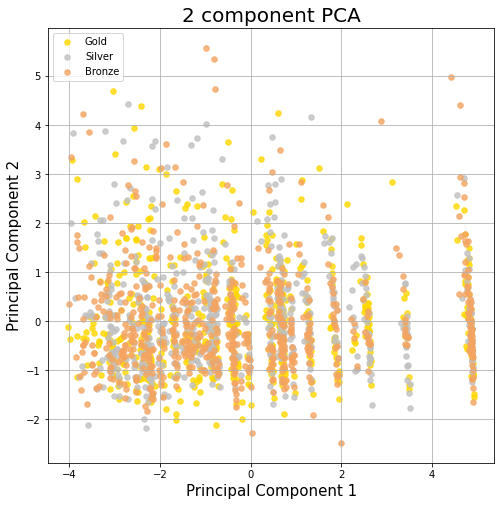

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
medals = ['Gold', 'Silver', 'Bronze']
colors = ['gold', 'silver', 'sandybrown']
for medal, color in zip(medals,colors):
  indicesToKeep = finalDf['Medal'] == medal
  ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color, s=30
               , alpha = 0.8)
ax.legend(medals)
ax.grid()

**Explained Variance**

La variança explicada ens informa de quanta informació (o variança) pot ser atribuïda a cadascún dels "principal components". Quan converteixes un dataset de n-dimensions a un dataset de 2 dimensions, perds algunes variances (informació) en el procés. 

In [25]:
# calculem el explained variance per cada component principal

print('Variance of each component:', pca.explained_variance_ratio_)
print('\nTotal Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [0.63101131 0.13606401]

Total Variance Explained: 76.71


Utilitzant l'atribut explained_variance_ratio_, podem veure que el primer component principal conté un 63,1% de la variança i el segon principal component un 13,6%. Ambdós junts, els 2 components contenen un 76,71% de la informació. 

Un cop aplicat l'anàlisi de components principals (PCA), podem veure tota la informació de cada component (PC1, PC2, ..., PC8)

In [26]:
from sklearn.pipeline import make_pipeline

pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_std)

modelo_pca = pca_pipe.named_steps['pca']

pd.DataFrame(data = modelo_pca.components_, columns = df_std.columns, index = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])

,Age,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
PC1,-0.030147,-0.103872,-0.370729,0.417621,0.410069,0.419604,0.432029,-0.381551
PC2,0.763902,0.638768,-0.022730,0.039956,0.042140,0.045378,0.043918,-0.023511
PC3,-0.616469,0.720823,0.168742,0.127478,0.128501,0.055370,0.111754,0.153584
PC4,0.187967,-0.247768,0.580961,0.266951,0.355514,0.083377,0.255852,0.543782
PC5,-0.004130,-0.003592,0.443718,-0.369085,-0.221104,0.741744,-0.004078,-0.260333
PC6,0.007650,-0.012224,-0.266379,0.441885,-0.661999,0.332587,0.026061,0.428994
PC7,0.010217,-0.006994,0.477713,0.545517,-0.321295,-0.296685,0.005124,-0.531761
PC8,0.000009,-0.000001,-0.000034,-0.327733,-0.311136,-0.251068,0.856009,0.000077


Per exemple, el primer component PC1 és el resultat de la combinació:

**PC1** = -0.030147Age - 0.103872Athlete_Rank - 0.370729Gold_Rank + 0.417621Gold + 0.410069Silver + 0.419604Bronze + 0.432029Total - 0.381551Rank_by_Total

els pesos assignats a les variables "Gold_Rank, Gold, Silver, Bronze i Total" son bastant similars i superiors als pesos assignats a la resta. Això significa que la primera component PC1 recolleix majoritariament la informació corresponent a medalles. 

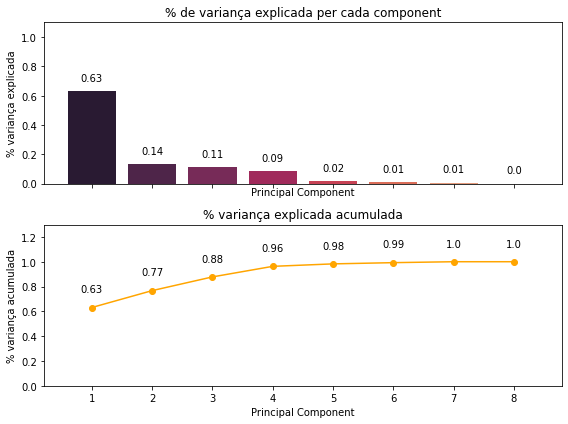

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

sns.barplot(x=np.arange(modelo_pca.n_components_)+1, y=modelo_pca.explained_variance_ratio_, palette="rocket", ax=ax1)
ax1.set_xticks(np.arange(len(var_num.columns)))
ax1.set_ylim(0, 1.1)
ax1.set_title('% de variança explicada per cada component')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('% variança explicada')

for x, y in zip(np.arange(len(var_num.columns)), modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax1.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')


var_acum = modelo_pca.explained_variance_ratio_.cumsum()
ax2.plot(np.arange(len(var_num.columns)), var_acum, marker = 'o', color = 'orange')

for x, y in zip(np.arange(len(var_num.columns)), var_acum):
    label = round(y, 2)
    ax2.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,15),
        ha='center'
    )
    
ax2.set_ylim(0, 1.3)
ax2.set_xticks(np.arange(modelo_pca.n_components_))
ax2.set_title('% variança explicada acumulada')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('% variança acumulada')

f.tight_layout();

En el gràfic de barres podem observar el percentatge de variança explicat per cada component, dels 8 atributs númerics que hem tingut en compte per al càlcul de la PCA. Així, el 1r component conté més del 0.6 de la variança (com hem vist anteriorment) i el 7è i 8è component pràcticament res.

la línia representa el percentatge de variança explicada acumulada.

## Exercici 3: Continua amb el conjunt de dades de tema esportiu que t'agradi i normalitza les dades tenint en compte els outliers.

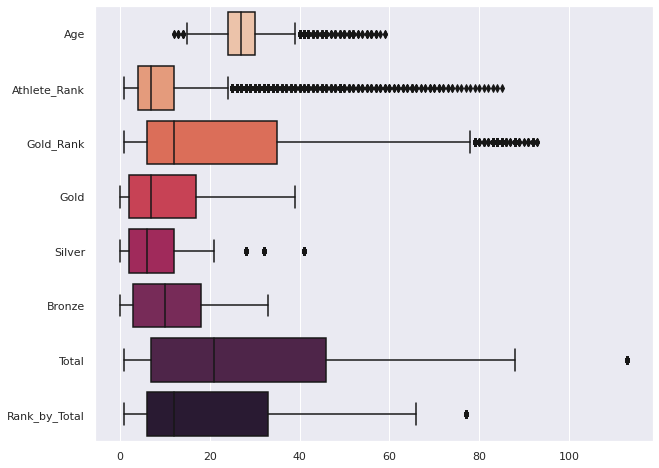

In [48]:
#Analitzem primer la dispersió dels valors numèrics per detectar possibles outliers:

plt.figure(figsize=(10,8))

sns.set(style="darkgrid")
sns.boxplot(data=var_num, orient='h', palette='rocket_r');

Podem veure possibles outliers als atributs '**Age**',  '**Total**',  '**Silver**' i 'Rank_by_Total' . 

In [30]:
round(var_num.describe(),2)

,Age,Athlete_Rank,Gold_Rank,Gold,Silver,Bronze,Total,Rank_by_Total
count,10787.00,10787.00,10787.00,10787.00,10787.00,10787.00,10787.00,10787.00
mean,27.36,10.35,22.96,11.46,10.70,11.65,33.81,20.35
std,5.51,10.41,23.51,12.17,11.54,9.32,31.77,19.77
min,12.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00
25%,24.00,4.00,6.00,2.00,2.00,3.00,7.00,6.00
50%,27.00,7.00,12.00,7.00,6.00,10.00,21.00,12.00
75%,30.00,12.00,35.00,17.00,12.00,18.00,46.00,33.00
max,66.00,85.00,93.00,39.00,41.00,33.00,113.00,77.00


In [31]:
outlier1 = var_num[(var_num['Age'] > 60)]
outlier1['Age']

2326    66
2327    66
2367    62
2368    62
7946    61
Name: Age, dtype: int64

Tot i que no es tracta d'un error ja que l'edat és real, sí que observem que el grup d'atletes majors de 60 anys no és significatiu (5 en total). Decidim treure'ls perquè estan molt lluny de la mitja (27 anys) i poden donar lloc a males interpretacions de les dades (variança). 

In [32]:
var_num = var_num.drop(2326)
var_num = var_num.drop(2327)
var_num = var_num.drop(2367)
var_num = var_num.drop(2368)
var_num = var_num.drop(7946)

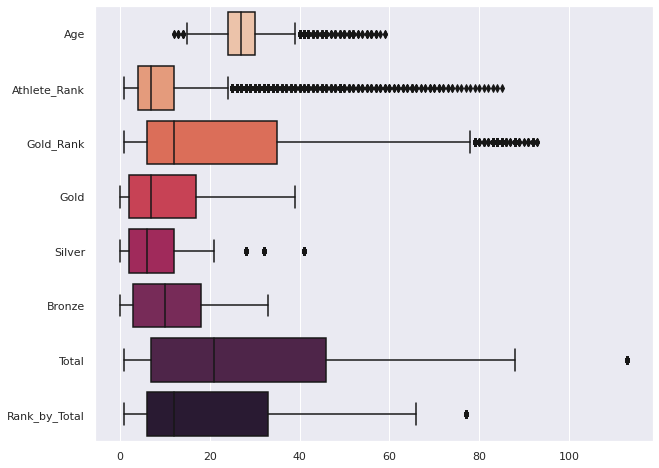

In [49]:
plt.figure(figsize=(10,8))

sns.set(style="darkgrid")
sns.boxplot(data=var_num, orient='h', palette='rocket_r');

veiem com ha canviat lleugerament la gràfica de dispersió de la variable 'Age' sense els 5 outliers.

Pels 3 atributs restants (Silver, Total, Rank_by_Total) hem seguit el mateix procediment que per l'atribut 'Age' però el resultat que ens hem trobat és completament diferent: Trobem que hi ha valor(s) molt allunyats però tots tenen una presència significativa al dataset amb més de 200, 400 o 700 atletes en cada atribut. 

In [39]:
outlier2 = var_num[(var_num['Silver'] > 20)]
outlier2['Silver'].value_counts()

41    716
32    471
28    451
21    421
Name: Silver, dtype: int64

In [35]:
outlier3 = var_num[(var_num['Total'] > 100)]
outlier3['Total'].value_counts()

113    716
Name: Total, dtype: int64

In [36]:
outlier4 = var_num[(var_num['Rank_by_Total'] > 70)]
outlier4['Rank_by_Total'].value_counts()

77    246
Name: Rank_by_Total, dtype: int64

Per aquest motiu, es decideix no fer res amb aquests 3 últims atributs. es considera que no hi ha outliers. 

In [44]:
var_num_norm = ss.fit_transform(var_num)
df_norm = pd.DataFrame(var_num_norm, columns = ['Age', 'Athlete_Rank', 'Gold_Rank','Gold', 'Silver', 'Bronze', 'Total', 'Rank_by_Total'])

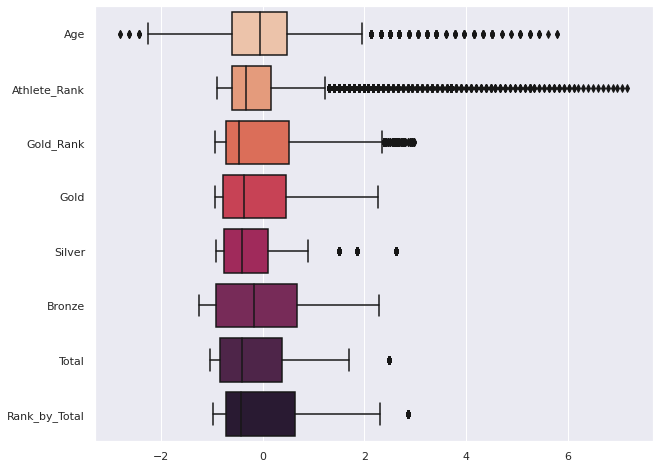

In [50]:
plt.figure(figsize=(10,8))

sns.set(style="darkgrid")
sns.boxplot(data=df_norm, orient='h', palette='rocket_r');